# Background
- Need data to fit to, but don't have any data yet (still missing some equipment)
- Generate some synthetic data (with noise?) and do a linear fit to find the constants.
- **Must normalize T_k and T_n s.t. the range of validity is between +-1.**

# Imports

In [17]:
import numpy as np
from scipy.spatial.transform import Rotation
import scipy.special
import scipy.optimize
from scipy.stats import chi2
import lmfit as lm
import pandas as pd
import pickle as pkl
import re
from copy import deepcopy
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.express as px

from hallprobecalib import hpc_ext_path
from hallprobecalib.hpcplots import spherical_scatter3d

In [2]:
# nicer plot formatting
def config_plots():
    #must run twice for some reason (glitch in Jupyter)
    for i in range(2):
        plt.rcParams['figure.figsize'] = [10, 8]
        plt.rcParams['axes.grid'] = True
        plt.rcParams['axes.axisbelow'] = True
        plt.rcParams['grid.linestyle'] = '--'
        plt.rcParams.update({'font.size': 18})
        
config_plots()

In [3]:
hpc_ext_path

'/home/ckampa/data/hallprobecalib_extras/'

In [4]:
plotdir = hpc_ext_path+'plots/fake_data/'
pkldir = '/home/ckampa/data/pickles/hallcalib/fake_data/'

In [5]:
###
k_max = 5 # |B| = 5 (Bergsma)
n_max = 2 # T = 2 (Bergsma)
l_max = 4 # from subtraction plots (Bergsma) to get to 5e-5.

# Model Function

In [6]:
params = lm.Parameters()

In [7]:
dict(params)

{}

In [29]:
def V_forward(Bs, ts, thetas, phis, **params):
    '''
    Parameters: 
    length-N numpy.arrays -- Bs (magnetic field), 
    ts (temperature), thetas (polar), phis (azimuthal)
    dictionary -- params where key is of form "c_knlm"
    and value is a float. Also needs "Bmin, Bmax, tmin, tmax" for scaling Chebyshev polynomial inputs
    
    Return: V (Hall voltage), a length-N numpy.array
    '''
    params_ = deepcopy(dict(params)) # wrap with dict for use in lmfit
    # normalizations
    B_sub = (params['Bmax'] + params['Bmin']) / 2
    B_div = (params['Bmax'] - params['Bmin']) / 2
    Bs_scaled = (Bs - B_sub) / B_div
    t_sub = (params['tmax'] + params['tmin']) / 2
    t_div = (params['tmax'] - params['tmin']) / 2
    ts_scaled = (ts - t_sub) / t_div
    # sum limits
    kmax = params['kmax']
    nmax = params['nmax']
    lmax = params['lmax']
    # euler angles (intrinsic)
    #theta0 = params['theta0'] # about y axis
    #phi0 = params['phi0'] # about z axis
    #psi0 = params['psi0'] # about x axis
    alpha0 = params['alpha0'] # about x axis
    beta0 = params['beta0'] # about x axis
    gamma0 = params['gamma0'] # about x axis
    # rotate
    xs = np.sin(thetas)*np.cos(phis)
    ys = np.sin(thetas)*np.sin(phis)
    zs = np.cos(thetas)
    pos = np.array([xs,ys,zs]).T
    rot = Rotation.from_euler('XYZ', np.array([alpha0,beta0,gamma0]))
    pos_rot = rot.apply(pos)
    thetas_rot = np.arccos(pos_rot[:,2]) # cos(theta) = z / r, r=1
    phis_rot = np.arctan2(pos_rot[:,1], pos_rot[:,0]) # tan(phi) = y / x
    
    # delete non-sum related parameters
    #[params.pop(key) for key in ['Bmin', 'Bmax', 'tmin', 'tmax', 'kmax', 'nmax', 'lmax', 'theta0', 'phi0']]
    [params.pop(key) for key in ['Bmin', 'Bmax', 'tmin', 'tmax', 'kmax', 'nmax', 'lmax', 'alpha0', 'beta0', 'gamma0']]
    # first determine ks, ns, and lms in use
    #kmax = np.max([int(i[2]) for i in params.keys()])
    #nmax = np.max([int(i[3]) for i in params.keys()])
    #lmax = np.max([int(i[4]) for i in params.keys()])
    #ks = list(set(int(i[2]) for i in params.keys()))
    #ns = list(set(int(i[3]) for i in params.keys()))
    #kmax = np.max(np.array(ks))
    #nmax = np.max(np.array(ns))
    #lms = list(set((i[4:]) for i in params.keys()))
    # loop through each lm and split into l and m
    # to store needed spherical harmonics in a dict
    #lms = []
    Ylms = {}
    for l in range(lmax+1):
        for m in range(l+1):
            #lms.append(f'{l}{m}')
            #Ylms[f'{l}{m}'] = np.real(scipy.special.sph_harm(m, l, phis, thetas))
            #Ylms[f'{l}{m}'] = np.real(scipy.special.sph_harm(m, l, phis+phi0, thetas+theta0))
            Ylms[f'{l}{m}'] = np.real(scipy.special.sph_harm(m, l, phis_rot, thetas_rot))
    lms = list(Ylms.keys())
    #for lm_ in lms:
    #    l, m = [int(i) for i in list(lm_)]
        # store spherical harmonic for each lm
    #    Ylms[lm_] = np.real(scipy.special.sph_harm(m, l, phis, thetas))
    
    # initialize coefficient array for Chebyshev (B)
    # starting with T_0(B) = 0 for all N data points
    #cs_B = [np.zeros_like(Bs)]
    cs_B = []
    # loop through all terms in model
    #### B ####
    #for k in ks:
    for k in range(kmax+1):
        # initialize coefficients to add to cs_B as zero
        cs = np.zeros_like(Bs)
        #### t ####
        #for n in ns:
        for n in range(nmax+1):
            # initialize another coeff array for Chebyshev (t)
            cs_t = np.zeros(nmax+1)
            # set the term we care about (n) to 1
            # and keep the rest = 0
            cs_t[n] = 1
            # generate Chebyshev (t)
            Tn_t = np.polynomial.chebyshev.chebval(ts_scaled, cs_t)
        
            # prepare array to store c_knlm * Y_lm
            params_ylms = np.zeros_like(Bs)
            #### theta, phi ####
            for lm_ in lms:
                params_ylms += params[f"c_{k}{n}{lm_}"] * Ylms[lm_]
            # add to cs (iteratively) as: T_n(t) * c_knlm * Y_lm
            cs += Tn_t * params_ylms
        # add completed cs array into cs_B
        cs_B.append(cs)
    cs_B = np.array(cs_B)
    # calculate V from all prepared terms
    V = np.polynomial.chebyshev.chebval(Bs_scaled, cs_B)#, tensor=True)
    return V

In [9]:
def V_forward_old(Bs, ts, thetas, phis, **params):
    '''
    Parameters: 
    length-N numpy.arrays -- Bs (magnetic field), 
    ts (temperature), thetas (polar), phis (azimuthal)
    dictionary -- params where key is of form "c_knlm"
    and value is a float. Also needs "Bmin, Bmax, tmin, tmax" for normalizing Chebyshev polynomials
    
    Return: V (Hall voltage), a length-N numpy.array
    '''
    params_ = deepcopy(dict(params)) # wrap with dict for use in lmfit
    # normalizations
    B_sub = (params['Bmax'] + params['Bmin']) / 2
    B_div = (params['Bmax'] - params['Bmin']) / 2
    Bs_normed = (Bs - B_sub) / B_div
    t_sub = (params['tmax'] + params['tmin']) / 2
    t_div = (params['tmax'] - params['tmin']) / 2
    ts_normed = (ts - t_sub) / t_div
    # delete non-sum related parameters
    [params.pop(key) for key in ['Bmin', 'Bmax', 'tmin', 'tmax']]
    # first determine ks, ns, and lms in use
    ks = list(set(int(i[2]) for i in params.keys()))
    ns = list(set(int(i[3]) for i in params.keys()))
    kmax = np.max(np.array(ks))
    nmax = np.max(np.array(ns))
    lms = list(set((i[4:]) for i in params.keys()))
    # loop through each lm and split into l and m
    # to store needed spherical harmonics in a dict
    Ylms = {}
    for lm_ in lms:
        l, m = [int(i) for i in list(lm_)]
        # store spherical harmonic for each lm
        Ylms[lm_] = np.real(scipy.special.sph_harm(m, l, phis, thetas))
    
    # initialize coefficient array for Chebyshev (B)
    # starting with T_0(B) = 0 for all N data points
    cs_B = [np.zeros_like(Bs)]
    # loop through all terms in model
    #### B ####
    for k in ks:
        # initialize coefficients to add to cs_B as zero
        cs = np.zeros_like(Bs)
        #### t ####
        for n in ns:
            # initialize another coeff array for Chebyshev (t)
            cs_t = np.zeros(nmax+1)
            # set the term we care about (n) to 1
            # and keep the rest = 0
            cs_t[n] = 1
            # generate Chebyshev (t)
            Tn_t = np.polynomial.chebyshev.chebval(ts_normed, cs_t)
            
            # prepare array to store c_knlm * Y_lm
            params_ylms = np.zeros_like(Bs)
            #### theta, phi ####
            for lm_ in lms:
                params_ylms += params[f"c_{k}{n}{lm_}"] * Ylms[lm_]
            # add to cs (iteratively) as: T_n(t) * c_knlm * Y_lm
            cs += Tn_t * params_ylms
        # add completed cs array into cs_B
        cs_B.append(cs)
    cs_B = np.array(cs_B)
    # calculate V from all prepared terms
    V = np.polynomial.chebyshev.chebval(Bs_normed, cs_B, tensor=True)
    return V

In [10]:
def V_forward_cheb2d(Bs, ts, thetas, phis, **params):
    '''
    Parameters: 
    length-N numpy.arrays -- Bs (magnetic field), 
    ts (temperature), thetas (polar), phis (azimuthal)
    dictionary -- params where key is of form "c_knlm"
    and value is a float. Also needs "Bmin, Bmax, tmin, tmax" for normalizing Chebyshev polynomials
    
    Return: V (Hall voltage), a length-N numpy.array
    '''
    params_ = deepcopy(dict(params)) # wrap with dict for use in lmfit
    # normalizations
    B_sub = (params['Bmax'] + params['Bmin']) / 2
    B_div = (params['Bmax'] - params['Bmin']) / 2
    Bs_normed = (Bs - B_sub) / B_div
    t_sub = (params['tmax'] + params['tmin']) / 2
    t_div = (params['tmax'] - params['tmin']) / 2
    ts_normed = (ts - t_sub) / t_div
    # delete non-sum related parameters
    [params.pop(key) for key in ['Bmin', 'Bmax', 'tmin', 'tmax']]
    # first determine ks, ns, and lms in use
    ks = list(set(int(i[2]) for i in params.keys()))
    ns = list(set(int(i[3]) for i in params.keys()))
    kmax = np.max(np.array(ks))
    nmax = np.max(np.array(ns))
    lms = list(set((i[4:]) for i in params.keys()))
    # loop through each lm and split into l and m
    # to store needed spherical harmonics in a dict
    Ylms = {}
    for lm_ in lms:
        l, m = [int(i) for i in list(lm_)]
        # store spherical harmonic for each lm
        Ylms[lm_] = np.real(scipy.special.sph_harm(m, l, phis, thetas))
    
    # initialize coefficient array for Chebyshev (B)
    # starting with T_0(B) = 0 for all N data points
    #cs_B = [np.zeros_like(Bs)]
    # loop through all terms in model
    #### B ####
    #for k in ks:
        # initialize coefficients to add to cs_B as zero
        #cs = np.zeros_like(Bs)
        #### t ####
        #for n in ns:
            # initialize another coeff array for Chebyshev (t)
          #  cs_t = np.zeros(nmax+1)
            # set the term we care about (n) to 1
            # and keep the rest = 0
         #   cs_t[n] = 1
            # generate Chebyshev (t)
        #    Tn_t = np.polynomial.chebyshev.chebval(ts_normed, cs_t)
            
            # prepare array to store c_knlm * Y_lm
       #     params_ylms = np.zeros_like(Bs)
            #### theta, phi ####
      #      for lm_ in lms:
     #           params_ylms += params[f"c_{k}{n}{lm_}"] * Ylms[lm_]
            # add to cs (iteratively) as: T_n(t) * c_knlm * Y_lm
    #        cs += Tn_t * params_ylms
        # add completed cs array into cs_B
   #     cs_B.append(cs)
  #  cs_B = np.array(cs_B)
    # calculate V from all prepared terms
 #   V = np.polynomial.chebyshev.chebval(Bs_normed, cs_B)
    
#    cs_B =
    '''
    cij = np.zeros((len(Bs),kmax+1, nmax+1))
    for k in ks:
        for n in ns:
            cij[:,k,n] = np.sum(np.array([params[f"c_{k}{n}{lm_}"] * Ylms[lm_] for lm_ in lms]), axis=0)
    #print(cij.shape)
    # 2D chebyshev
    V = np.array([np.polynomial.chebyshev.chebval2d(B_, t_, cij_) for B_, t_, cij_ in zip(Bs_normed, ts_normed, cij)])
    return V
    '''

    cij = np.zeros((len(Bs),kmax+1, nmax+1))
    for k in ks:
        for n in ns:
            cij[:,k,n] = np.sum(np.array([params[f"c_{k}{n}{lm_}"] * Ylms[lm_] for lm_ in lms]), axis=0)
    #print(cij.shape)
    # 2D chebyshev
    V = np.array([np.polynomial.chebyshev.chebval2d(B_, t_, cij_) for B_, t_, cij_ in zip(Bs_normed, ts_normed, cij)])
    return V

In [170]:
df[['V_obs', 'V_lsq']].values

array([[-383064.44057394, -383125.44388354],
       [-383170.82702507, -383125.44388354],
       [-383123.90605572, -383125.44388354],
       ...,
       [-144078.13206824, -144130.76690426],
       [-144046.74661534, -144130.76690426],
       [-144145.38527169, -144130.76690426]])

In [316]:
V_forward(df_['B'], df_['Temp'], df_['Theta'], df_['Phi'], **result.params)

0          49333.065120
25         49333.065120
50         49333.065120
75         49333.065120
100        49333.065120
               ...     
3125770   -51264.052030
3125795   -51264.534280
3125820   -51262.260761
3125845   -51258.663537
3125870   -51256.163975
Name: B, Length: 5760, dtype: float64

In [435]:
V1 = V_forward(df_['B'], df_['Temp'], df_['Theta'], df_['Phi'], **result.params).values

In [436]:
V2 = V_forward_cheb2d(df_['B'], df_['Temp'], df_['Theta'], df_['Phi'], **result.params)

In [437]:
V1

array([ 49333.06511952,  49333.06511952,  49333.06511952, ...,
       -51262.26076122, -51258.66353662, -51256.16397505])

In [438]:
V2

array([ 49333.06511952,  49333.06511952,  49333.06511952, ...,
       -51262.26076122, -51258.66353662, -51256.16397505])

In [441]:
np.isclose(V1,V2).all()

True

In [442]:
%timeit V1 = V_forward(df_['B'], df_['Temp'], df_['Theta'], df_['Phi'], **result.params).values

14.4 ms ± 74.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [443]:
%timeit V2 = V_forward_cheb2d(df_['B'], df_['Temp'], df_['Theta'], df_['Phi'], **result.params)

95.7 ms ± 795 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [428]:
np.diag(V2)

array([[ 49333.06511952,      0.        ,      0.        , ...,
             0.        ,      0.        ,      0.        ],
       [     0.        ,  49333.06511952,      0.        , ...,
             0.        ,      0.        ,      0.        ],
       [     0.        ,      0.        ,  49333.06511952, ...,
             0.        ,      0.        ,      0.        ],
       ...,
       [     0.        ,      0.        ,      0.        , ...,
        -51262.26076122,      0.        ,      0.        ],
       [     0.        ,      0.        ,      0.        , ...,
             0.        , -51258.66353662,      0.        ],
       [     0.        ,      0.        ,      0.        , ...,
             0.        ,      0.        , -51256.16397505]])

In [420]:
cij[1,2]

(5760,)

In [337]:
V1.shape

(5760,)

In [338]:
V2.shape

(5760, 5760)

In [312]:
np.sum(V2, axis=1)

array([ 3028.01957558,  3028.01957558,  3028.01957558, ...,
       -2499.03925119, -2489.64821008, -2484.5471557 ])

In [313]:
V1

array([ 49333.06511952,  49333.06511952,  49333.06511952, ...,
       -51262.26076122, -51258.66353662, -51256.16397505])

In [314]:
V2 - V1

array([[-7.27595761e-12, -7.27595761e-12, -7.27595761e-12, ...,
         1.02722115e+05,  1.02718517e+05,  1.02716018e+05],
       [-7.27595761e-12, -7.27595761e-12, -7.27595761e-12, ...,
         1.02722115e+05,  1.02718517e+05,  1.02716018e+05],
       [-7.27595761e-12, -7.27595761e-12, -7.27595761e-12, ...,
         1.02722115e+05,  1.02718517e+05,  1.02716018e+05],
       ...,
       [-9.84658431e+04, -9.84658431e+04, -9.84658431e+04, ...,
         7.27595761e-12, -3.59722460e+00, -6.09678617e+00],
       [-9.84633037e+04, -9.84633037e+04, -9.84633037e+04, ...,
         3.59722460e+00, -7.27595761e-12, -2.49956157e+00],
       [-9.84615553e+04, -9.84615553e+04, -9.84615553e+04, ...,
         6.09678617e+00,  2.49956157e+00, -7.27595761e-12]])

In [291]:
len(V2)

33177600

In [292]:
V2

array([ 49333.06511952,  49333.06511952,  49333.06511952, ...,
       -51256.16397505, -51256.16397505, -51256.16397505])

In [203]:
params_full

{'c_0000': -568833.5715684674,
 'c_0010': -1222346.401758556,
 'c_0011': 902789.648709938,
 'c_0020': 372770.90485195577,
 'c_0021': -662430.2689479465,
 'c_0022': 1348850.3296133426,
 'c_0100': 348593.1570303627,
 'c_0110': 1636793.5014046014,
 'c_0111': -1462742.8985006786,
 'c_0120': -1108315.6573891372,
 'c_0121': 1025711.1525122811,
 'c_0122': 1854997.286273766,
 'c_0200': 381616.56882439746,
 'c_0210': 971944.074413291,
 'c_0211': -5200.489543624544,
 'c_0220': 1358256.795322075,
 'c_0221': 159513.78446702336,
 'c_0222': 823838.3174124715,
 'c_1000': 1634149.511101087,
 'c_1010': -1171462.1743541295,
 'c_1011': -579889.7227965868,
 'c_1020': -1739678.463533133,
 'c_1021': 273844.13131041004,
 'c_1022': -428244.13214700227,
 'c_1100': -678275.6454047029,
 'c_1110': -698070.9961308317,
 'c_1111': -562311.0573959867,
 'c_1120': -968080.5138160832,
 'c_1121': 1207371.6540466407,
 'c_1122': 785296.0549985286,
 'c_1200': 2243125.3809860554,
 'c_1210': -1742742.5258127593,
 'c_1211': -1

In [30]:
def gen_data(Bs, ts, thetas, phis, sigma, params):
    '''
    Parameters: 
    length-N numpy.arrays -- Bs (magnetic field), 
    ts (temperature), thetas (polar), phis (azimuthal)
    float -- sigma (noise standard deviation)
    
    Return: df, pandas.DataFrame
    '''
    # create meshgrid for all input independent variables
    B, Te, Th, Ph = np.meshgrid(Bs, ts, thetas, phis)
    # flatten all to 1D arrays
    B = B.flatten()
    Te = Te.flatten()
    Th = Th.flatten()
    Ph = Ph.flatten()
    
    # create pandas.DataFrame to store information from each data point
    df = pd.DataFrame({"B":B, "Temp":Te, "Theta": Th, "Phi": Ph})
    # add columns for angles in degrees for convenience
    df["Theta_deg"] = np.degrees(df.Theta)
    df["Phi_deg"] = np.degrees(df.Phi)
    # use forward function to generate voltage data and store in new column
    #df["V_obs"] = V_forward(df.B.values, df.Temp.values, df.Theta.values, df.Phi.values, **params)
    df["V_exact"] = V_forward(df.B, df.Temp, df.Theta, df.Phi, **params)
    # inject noise
    df["V_obs"] = df["V_exact"] + np.random.normal(loc=0.0, scale=sigma, size=len(df))
    # set sigma as a column
    df["sigma_V"] = sigma
    
    return df

# Generate Data

In [92]:
N = "12"

In [93]:
# all random
kmax = 3
nmax = 2
lmax = 2 # 7 # 2
scale = 1e6

In [94]:
nparams = int((kmax+1)*(nmax+1)*(lmax+1)*(lmax+2)/2)

In [95]:
pvals = np.random.normal(loc=0, scale=scale, size=nparams)
params_knlm = {}
i = 0
for k in range(kmax+1):
    for n in range(nmax+1):
        for l in range(lmax+1):
            for m in range(l+1):
                params_knlm[f'c_{k}{n}{l}{m}'] = pvals[i]
                i += 1

In [96]:
params_knlm

{'c_0000': -568833.5715684674,
 'c_0010': -1222346.401758556,
 'c_0011': 902789.648709938,
 'c_0020': 372770.90485195577,
 'c_0021': -662430.2689479465,
 'c_0022': 1348850.3296133426,
 'c_0100': 348593.1570303627,
 'c_0110': 1636793.5014046014,
 'c_0111': -1462742.8985006786,
 'c_0120': -1108315.6573891372,
 'c_0121': 1025711.1525122811,
 'c_0122': 1854997.286273766,
 'c_0200': 381616.56882439746,
 'c_0210': 971944.074413291,
 'c_0211': -5200.489543624544,
 'c_0220': 1358256.795322075,
 'c_0221': 159513.78446702336,
 'c_0222': 823838.3174124715,
 'c_1000': 1634149.511101087,
 'c_1010': -1171462.1743541295,
 'c_1011': -579889.7227965868,
 'c_1020': -1739678.463533133,
 'c_1021': 273844.13131041004,
 'c_1022': -428244.13214700227,
 'c_1100': -678275.6454047029,
 'c_1110': -698070.9961308317,
 'c_1111': -562311.0573959867,
 'c_1120': -968080.5138160832,
 'c_1121': 1207371.6540466407,
 'c_1122': 785296.0549985286,
 'c_1200': 2243125.3809860554,
 'c_1210': -1742742.5258127593,
 'c_1211': -1

In [97]:
params_full = deepcopy(params_knlm)
# add scaling and sum limits
params_full['Bmin'] = 0.
params_full['Bmax'] = 2. # good for Mu2e DS
params_full['tmin'] = 10. # deg C (~50 deg F)
params_full['tmax'] = 40. # deg C (~100 deg F)
params_full['kmax'] = kmax
params_full['nmax'] = nmax
params_full['lmax'] = lmax
#params_full['theta0'] = np.pi/2
#params_full['phi0'] = np.pi/2
params_full['alpha0'] = 0.1
params_full['beta0'] = np.pi/4
params_full['gamma0'] = -np.pi/8

In [98]:
{'param':list(params_full.keys()), 'value':list(params_full.values())}

{'param': ['c_0000',
  'c_0010',
  'c_0011',
  'c_0020',
  'c_0021',
  'c_0022',
  'c_0100',
  'c_0110',
  'c_0111',
  'c_0120',
  'c_0121',
  'c_0122',
  'c_0200',
  'c_0210',
  'c_0211',
  'c_0220',
  'c_0221',
  'c_0222',
  'c_1000',
  'c_1010',
  'c_1011',
  'c_1020',
  'c_1021',
  'c_1022',
  'c_1100',
  'c_1110',
  'c_1111',
  'c_1120',
  'c_1121',
  'c_1122',
  'c_1200',
  'c_1210',
  'c_1211',
  'c_1220',
  'c_1221',
  'c_1222',
  'c_2000',
  'c_2010',
  'c_2011',
  'c_2020',
  'c_2021',
  'c_2022',
  'c_2100',
  'c_2110',
  'c_2111',
  'c_2120',
  'c_2121',
  'c_2122',
  'c_2200',
  'c_2210',
  'c_2211',
  'c_2220',
  'c_2221',
  'c_2222',
  'c_3000',
  'c_3010',
  'c_3011',
  'c_3020',
  'c_3021',
  'c_3022',
  'c_3100',
  'c_3110',
  'c_3111',
  'c_3120',
  'c_3121',
  'c_3122',
  'c_3200',
  'c_3210',
  'c_3211',
  'c_3220',
  'c_3221',
  'c_3222',
  'Bmin',
  'Bmax',
  'tmin',
  'tmax',
  'kmax',
  'nmax',
  'lmax',
  'alpha0',
  'beta0',
  'gamma0'],
 'value': [-568833.57

In [99]:
# write out parameters
df_params = pd.DataFrame({'param':list(params_full.keys()), 'value':list(params_full.values())})
#df_params.to_pickle('/home/ckampa/data/pickles/hallcalib/fake_data/hall_voltage_05_params.p')
#df_params.to_pickle('/home/ckampa/data/pickles/hallcalib/fake_data/hall_voltage_06_params.p')
df_params.to_pickle(f'/home/ckampa/data/pickles/hallcalib/fake_data/hall_voltage_{N}_params.p')

In [100]:
df_params

,param,value
0,c_0000,-5.688336e+05
1,c_0010,-1.222346e+06
2,c_0011,9.027896e+05
3,c_0020,3.727709e+05
4,c_0021,-6.624303e+05
...,...,...
77,nmax,2.000000e+00
78,lmax,2.000000e+00
79,alpha0,1.000000e-01
80,beta0,7.853982e-01


In [101]:
params = deepcopy(params_full)

In [102]:
# generate starting conditions
Nphi, Ntheta, NB, Nt = (360, 181, 8, 6)
#Nphi, Ntheta, NB, Nt = (360, 181, 4, 3)
phis = np.linspace(0, 2*np.pi - 2*np.pi/Nphi, Nphi)
thetas = np.linspace(0, np.pi, Ntheta)
Bs = np.linspace(params['Bmin'], params['Bmax'], NB)
ts = np.linspace(params['tmin'], params['tmax'], Nt)
sigma = 50. # from Hall probe in zero field data

# call forward data generation function and store in dataframe
df_test = gen_data(Bs, ts, thetas, phis, sigma, params)

In [103]:
#df_test.to_pickle('/home/ckampa/data/pickles/hallcalib/fake_data/hall_voltage_05_data.p')
#df_test.to_pickle('/home/ckampa/data/pickles/hallcalib/fake_data/hall_voltage_06_data.p')
df_test.to_pickle(f'/home/ckampa/data/pickles/hallcalib/fake_data/hall_voltage_{N}_data.p')

In [104]:
df_test

,B,Temp,Theta,Phi,Theta_deg,Phi_deg,V_exact,V_obs,sigma_V
0,0.0,10.0,0.000000,0.000000,0.0,0.0,-1.844973e+06,-1.844983e+06,50.0
1,0.0,10.0,0.000000,0.017453,0.0,1.0,-1.844973e+06,-1.844897e+06,50.0
2,0.0,10.0,0.000000,0.034907,0.0,2.0,-1.844973e+06,-1.844982e+06,50.0
3,0.0,10.0,0.000000,0.052360,0.0,3.0,-1.844973e+06,-1.844943e+06,50.0
4,0.0,10.0,0.000000,0.069813,0.0,4.0,-1.844973e+06,-1.845018e+06,50.0
...,...,...,...,...,...,...,...,...,...
3127675,2.0,40.0,3.141593,6.195919,180.0,355.0,-7.686231e+05,-7.686738e+05,50.0
3127676,2.0,40.0,3.141593,6.213372,180.0,356.0,-7.686231e+05,-7.686612e+05,50.0
3127677,2.0,40.0,3.141593,6.230825,180.0,357.0,-7.686231e+05,-7.685884e+05,50.0
3127678,2.0,40.0,3.141593,6.248279,180.0,358.0,-7.686231e+05,-7.686347e+05,50.0


In [105]:
df = df_test

In [106]:
N

'12'

In [107]:
# loading
df = pd.read_pickle(f'/home/ckampa/data/pickles/hallcalib/fake_data/hall_voltage_{N}_data.p')

### Old (pick 12 nonzero params)

In [488]:
# parameter keys
#params_knlm = ["1110", "1122", "1210", "1222", "2110", "2122",
#               "2210", "2222", "3110", "3122", "3210", "3222",]
#params_knlm = ["1111", "1122", "1211", "1222", "2111", "2122",
#               "2211", "2222", "3111", "3122", "3211", "3222",]

params_knlm = ["1110", "1111", "1210", "1211", "2110", "2111",
               "2210", "2211", "3110", "3111", "3210", "3211",]


base = 1e6 # 1e5
# pick realistic values
#params_vals = [base, base*1e-2, base*1e-2, base*1e-3, base*1e-2, base*1e-3,
#               base*1e-3, base*1e-4, base*1e-3, base*1e-4, base*1e-4, base*1e-5]
params_vals = [base, base, base*1e-2, base*1e-3, base*1e-2, base*1e-3,
               base*1e-3, base*1e-4, base*1e-3, base*1e-4, base*1e-4, base*1e-5]
scale_factors = list(1 + np.random.normal(scale=1e-1, size=len(params_vals)))
params_vals = [p*sf for p, sf in zip(params_vals, scale_factors)]
# generate dictionary
params = {f"c_{p}":v for p,v in zip(params_knlm, params_vals)}
# add normalizations
params['Bmin'] = 0.
params['Bmax'] = 2. # good for Mu2e DS
params['tmin'] = 10. # deg C (~50 deg F)
params['tmax'] = 40. # deg C (~100 deg F)

In [489]:
# generate starting conditions
Nphi, Ntheta, NB, Nt = (360, 181, 8, 6)
#Nphi, Ntheta, NB, Nt = (360, 181, 4, 3)
phis = np.linspace(0, 2*np.pi - 2*np.pi/Nphi, Nphi)
thetas = np.linspace(0, np.pi, Ntheta)
Bs = np.linspace(params['Bmin'], params['Bmax'], NB)
ts = np.linspace(params['tmin'], params['tmax'], Nt)
sigma = 0. # from Hall probe in zero field data

# call forward data generation function and store in dataframe
df_test = gen_data(Bs, ts, thetas, phis, sigma, params)

In [507]:
#df_test[(df_test['Theta'] >= np.pi/2) & (df_test['B'] >= 1.0)][:365]
df_test[(df_test['Theta'] >= np.pi/2) & (df_test['B'] >= 0)][:365]

,B,Temp,Theta,Phi,Theta_deg,Phi_deg,V_obs,sigma_V
32400,0.0,10.0,1.570796,0.000000,90.0,0.0,-33576.359404,0.0
32401,0.0,10.0,1.570796,0.017453,90.0,1.0,-33571.245562,0.0
32402,0.0,10.0,1.570796,0.034907,90.0,2.0,-33555.905593,0.0
32403,0.0,10.0,1.570796,0.052360,90.0,3.0,-33530.344170,0.0
32404,0.0,10.0,1.570796,0.069813,90.0,4.0,-33494.569080,0.0
...,...,...,...,...,...,...,...,...
32760,0.0,10.0,1.588250,0.000000,91.0,0.0,-34520.574152,0.0
32761,0.0,10.0,1.588250,0.017453,91.0,1.0,-34515.461089,0.0
32762,0.0,10.0,1.588250,0.034907,91.0,2.0,-34500.123456,0.0
32763,0.0,10.0,1.588250,0.052360,91.0,3.0,-34474.565927,0.0


In [479]:
df_test['V_obs'].describe()

count    3.127680e+06
mean     5.918136e-15
std      7.507304e+03
min     -3.406271e+04
25%     -2.326518e+03
50%      0.000000e+00
75%      2.326734e+03
max      3.488139e+04
Name: V_obs, dtype: float64

In [473]:
df_test['V_obs'].describe()

count    3.127680e+06
mean     5.918136e-15
std      7.507304e+03
min     -3.406271e+04
25%     -2.326518e+03
50%      0.000000e+00
75%      2.326734e+03
max      3.488139e+04
Name: V_obs, dtype: float64

In [510]:
df_

,B,Temp,Theta,Phi,Theta_deg,Phi_deg,V_obs,sigma_V
0,0.0,10.0,0.000000,0.000000,0.0,0.0,49373.948919,50.0
25,0.0,10.0,0.000000,0.436332,0.0,25.0,49336.861489,50.0
50,0.0,10.0,0.000000,0.872665,0.0,50.0,49344.012691,50.0
75,0.0,10.0,0.000000,1.308997,0.0,75.0,49331.786667,50.0
100,0.0,10.0,0.000000,1.745329,0.0,100.0,49379.704953,50.0
...,...,...,...,...,...,...,...,...
3125770,2.0,40.0,3.054326,4.363323,175.0,250.0,-51229.757882,50.0
3125795,2.0,40.0,3.054326,4.799655,175.0,275.0,-51305.014140,50.0
3125820,2.0,40.0,3.054326,5.235988,175.0,300.0,-51380.171673,50.0
3125845,2.0,40.0,3.054326,5.672320,175.0,325.0,-51336.241071,50.0


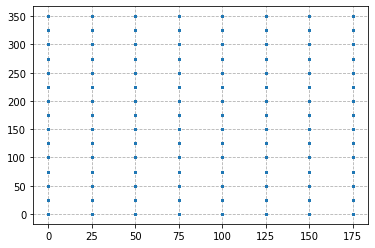

In [511]:
plt.scatter(df_.Theta_deg, df_.Phi_deg, s=1)

In [508]:
df_params

,k,n,l,m,val,key
0,1,1,1,0,102925.180085,c_1110
1,1,1,2,2,1114.682186,c_1122
2,1,2,1,0,1078.493529,c_1210
3,1,2,2,2,121.433947,c_1222
4,2,1,1,0,1094.086933,c_2110
5,2,1,2,2,89.561022,c_2122
6,2,2,1,0,100.930980,c_2210
7,2,2,2,2,10.004415,c_2222
8,3,1,1,0,108.587339,c_3110
9,3,1,2,2,9.003465,c_3122


In [509]:
result.params

name,value,standard error,relative error,initial value,min,max,vary
c_1100,5.12554083,6.00704789,(117.20%),0,-inf,inf,True
c_1110,102924.719,4.02386323,(0.00%),0,-inf,inf,True
c_1111,5.91019285,8.74752673,(148.01%),0,-inf,inf,True
c_1120,-2.50098468,4.18789866,(167.45%),0,-inf,inf,True
c_1121,0.50169836,7.81016451,(1556.75%),0,-inf,inf,True
c_1122,1111.04831,9.02767207,(0.81%),0,-inf,inf,True
c_1200,-7.55417908,5.12319035,(67.82%),0,-inf,inf,True
c_1210,1074.32264,3.43172239,(0.32%),0,-inf,inf,True
c_1211,1.03486252,7.46004412,(720.87%),0,-inf,inf,True
c_1220,6.81631958,3.57163057,(52.40%),0,-inf,inf,True


## Construct Parameters

- Use same non-zero params to start, for easy comparison. But later try c_1010 and c_0110 as I think these two are more likely to be the dominant terms: $V \approx \cos(\theta)*(c_{1010}*B + c_{0110} * t)$.

In [91]:
Bmin = 0.; Bmax = 2.; tmin = 10.; tmax = 40.

In [49]:
# parameter keys
params_knlm = ["1110", "1122", "1210", "1222", "2110", "2122",
               "2210", "2222", "3110", "3122", "3210", "3222",]
base = 1e5
# pick realistic values
params_vals = [base, base*1e-2, base*1e-2, base*1e-3, base*1e-2, base*1e-3,
               base*1e-3, base*1e-4, base*1e-3, base*1e-4, base*1e-4, base*1e-5]
scale_factors = list(1 + np.random.normal(scale=1e-1, size=len(params_vals)))
params_vals = [p*sf for p, sf in zip(params_vals, scale_factors)]
# generate dictionary
params = {f"c_{p}":v for p,v in zip(params_knlm, params_vals)}
# add scalings
params['Bmin'] = 0.
params['Bmax'] = 2. # good for Mu2e DS
params['tmin'] = 10. # deg C (~50 deg F)
params['tmax'] = 40. # deg C (~100 deg F)

- Temperature range a bit excessive.

In [50]:
params

{'c_1110': 102925.18008477692,
 'c_1122': 1114.6821856905417,
 'c_1210': 1078.4935287996536,
 'c_1222': 121.43394676593475,
 'c_2110': 1094.0869334348813,
 'c_2122': 89.56102198931241,
 'c_2210': 100.9309795755187,
 'c_2222': 10.004414878642933,
 'c_3110': 108.58733945516138,
 'c_3122': 9.003465231103727,
 'c_3210': 11.293278257402228,
 'c_3222': 1.0233450476111123,
 'Bmin': 0.0,
 'Bmax': 2.0,
 'tmin': 10.0,
 'tmax': 40.0}

In [51]:
ks = [int(p[0]) for p in params_knlm]
ns = [int(p[1]) for p in params_knlm]
ls = [int(p[2]) for p in params_knlm]
ms = [int(p[3]) for p in params_knlm]

In [52]:
ks, ns, ls, ms

([1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3],
 [1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2],
 [1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2],
 [0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2])

In [53]:
df_params = pd.DataFrame({'k':ks, 'n': ns, 'l': ls, 'm': ms, 'val': params_vals})

In [54]:
df_params

,k,n,l,m,val
0,1,1,1,0,102925.180085
1,1,1,2,2,1114.682186
2,1,2,1,0,1078.493529
3,1,2,2,2,121.433947
4,2,1,1,0,1094.086933
5,2,1,2,2,89.561022
6,2,2,1,0,100.930980
7,2,2,2,2,10.004415
8,3,1,1,0,108.587339
9,3,1,2,2,9.003465


In [55]:
df_params.to_pickle('/home/ckampa/data/pickles/hallcalib/fake_data/hall_voltage_04_params.p')

In [56]:
df_params.max()

k           3.000000
n           2.000000
l           2.000000
m           2.000000
val    102925.180085
dtype: float64

## Generate Validation Data

In [103]:
lmax = 2
(lmax+1)*(lmax+2)/2

6.0

In [104]:
4 * 4

16

In [69]:
# generate starting conditions
Nphi, Ntheta, NB, Nt = (360, 181, 8, 6)
#Nphi, Ntheta, NB, Nt = (360, 181, 4, 3)
phis = np.linspace(0, 2*np.pi - 2*np.pi/Nphi, Nphi)
thetas = np.linspace(0, np.pi, Ntheta)
Bs = np.linspace(params['Bmin'], params['Bmax'], NB)
ts = np.linspace(params['tmin'], params['tmax'], Nt)
sigma = 50. # from Hall probe in zero field data

# call forward data generation function and store in dataframe
df = gen_data(Bs, ts, thetas, phis, sigma, params)

In [70]:
df

,B,Temp,Theta,Phi,Theta_deg,Phi_deg,V_obs,sigma_V
0,0.0,10.0,0.000000,0.000000,0.0,0.0,49373.948919,50.0
1,0.0,10.0,0.000000,0.017453,0.0,1.0,49276.910000,50.0
2,0.0,10.0,0.000000,0.034907,0.0,2.0,49347.446264,50.0
3,0.0,10.0,0.000000,0.052360,0.0,3.0,49280.981389,50.0
4,0.0,10.0,0.000000,0.069813,0.0,4.0,49289.726306,50.0
...,...,...,...,...,...,...,...,...
3127675,2.0,40.0,3.141593,6.195919,180.0,355.0,-51514.761645,50.0
3127676,2.0,40.0,3.141593,6.213372,180.0,356.0,-51552.756737,50.0
3127677,2.0,40.0,3.141593,6.230825,180.0,357.0,-51467.736212,50.0
3127678,2.0,40.0,3.141593,6.248279,180.0,358.0,-51485.928410,50.0


In [72]:
# number of days to collect this data, assuming ~8 seconds / point
len(df) * 8 / 60 / 60 / 24

289.59999999999997

In [73]:
#df.to_pickle('fake_data/hall_voltage_01_data.p')
#df.to_pickle('/home/ckampa/data/pickles/hallcalib/fake_data/hall_voltage_02_data.p')
#df.to_pickle('/home/ckampa/data/pickles/hallcalib/fake_data/hall_voltage_03_data.p')
df.to_pickle('/home/ckampa/data/pickles/hallcalib/fake_data/hall_voltage_04_data.p')

# Test Fit

In [140]:
#df_ = df[np.isin(df.Theta_deg, df.Theta_deg.unique()[::25]) \
#             & np.isin(df.Phi_deg, df.Phi_deg.unique()[::25])]

#df_ = df[np.isin(df.Theta_deg, df.Theta_deg.unique()[::25]) \
#             & np.isin(df.Phi_deg, df.Phi_deg.unique()[::50])]

df_ = df[np.isin(df.Theta_deg, df.Theta_deg.unique()[::50]) \
             & np.isin(df.Phi_deg, df.Phi_deg.unique()[::100])]
#df_ = df[np.isin(df.Phi_deg, df.Phi_deg.unique()[::25])]
#df_ = df_.query('(Theta_deg <= 10) | (Theta_deg >= 170)')

In [141]:
df_

,B,Temp,Theta,Phi,Theta_deg,Phi_deg,V_exact,V_obs,sigma_V
0,0.0,10.0,0.000000,0.000000,0.0,0.0,-1.844973e+06,-1.844983e+06,50.0
100,0.0,10.0,0.000000,1.745329,0.0,100.0,-1.844973e+06,-1.844941e+06,50.0
200,0.0,10.0,0.000000,3.490659,0.0,200.0,-1.844973e+06,-1.845018e+06,50.0
300,0.0,10.0,0.000000,5.235988,0.0,300.0,-1.844973e+06,-1.845078e+06,50.0
18000,0.0,10.0,0.872665,0.000000,50.0,0.0,-3.306075e+06,-3.306054e+06,50.0
...,...,...,...,...,...,...,...,...,...
3098820,2.0,40.0,1.745329,5.235988,100.0,300.0,-3.188472e+05,-3.189109e+05,50.0
3116520,2.0,40.0,2.617994,0.000000,150.0,0.0,-4.791697e+05,-4.791719e+05,50.0
3116620,2.0,40.0,2.617994,1.745329,150.0,100.0,-8.297218e+05,-8.297596e+05,50.0
3116720,2.0,40.0,2.617994,3.490659,150.0,200.0,6.811594e+05,6.811630e+05,50.0


In [142]:
df_.Theta.unique()

array([0.        , 0.87266463, 1.74532925, 2.61799388])

In [143]:
df_.Phi.unique()

array([0.        , 1.74532925, 3.4906585 , 5.23598776])

In [112]:
abs(df_.V_exact).max()

5301117.334392445

In [113]:
2/9

0.2222222222222222

In [114]:
len(df_.Theta_deg.unique()), len(df_.Phi_deg.unique())

(4, 4)

In [115]:
# days to collect data at 8 s / point. Not bad...
len(df_) * 8 / 60 / 60 / 24

0.07111111111111111

In [84]:
params_knlm

{'c_0000': -1431.7007827589548,
 'c_0010': 31871.566493799335,
 'c_0011': 65534.3092302834,
 'c_0020': -191503.40942472243,
 'c_0021': 84041.86866344385,
 'c_0022': -50232.14601891709,
 'c_0100': -19701.231720255753,
 'c_0110': 81839.00830720077,
 'c_0111': -41165.28631481033,
 'c_0120': 104482.03879761441,
 'c_0121': -38304.87549224862,
 'c_0122': 41574.69301083676,
 'c_0200': 206166.34575813194,
 'c_0210': -253018.61003345167,
 'c_0211': 102528.44251941863,
 'c_0220': 102312.96884467501,
 'c_0221': -49164.235058448634,
 'c_0222': -91188.71757014107,
 'c_1000': -10476.265503800629,
 'c_1010': 83424.15467397805,
 'c_1011': -86763.52619185741,
 'c_1020': -64259.859676338005,
 'c_1021': -110023.19598151988,
 'c_1022': 112960.07029952864,
 'c_1100': -99964.8522721947,
 'c_1110': -49111.02215530521,
 'c_1111': -120007.8928551712,
 'c_1120': 38219.76858631753,
 'c_1121': -45770.55017161837,
 'c_1122': -136577.5125133906,
 'c_1200': 180434.67582181282,
 'c_1210': 100532.16001420346,
 'c_1211

In [144]:
Bmin = 0.
Bmax = 2. # good for Mu2e DS
tmin = 10. # deg C (~50 deg F)
tmax = 40. # deg C (~100 deg F)

In [145]:
Bmin, Bmax, tmin, tmax

(0.0, 2.0, 10.0, 40.0)

In [146]:
#kmax = 3
#nmax = 2
#lmax = 2

In [147]:
kmax, nmax, lmax

(3, 2, 2)

In [195]:
# construct model
model = lm.Model(V_forward, independent_vars=['Bs', 'ts', 'thetas', 'phis'])
params = lm.Parameters()
for k in range(kmax+1):
    for n in range(nmax+1):
        for l in range(lmax+1):
            for m in range(l+1):
                params.add(f'c_{k}{n}{l}{m}', value=0)
'''
for k in range(1, kmax+1):
    for n in range(1, nmax+1):
        for l in range(lmax+1):
            for m in range(l+1):
                params.add(f'c_{k}{n}{l}{m}', value=0)
'''
params.add('Bmin', value=Bmin, vary=False)
params.add('Bmax', value=Bmax, vary=False)
params.add('tmin', value=tmin, vary=False)
params.add('tmax', value=tmax, vary=False)
params.add('kmax', value=kmax, vary=False)
params.add('nmax', value=nmax, vary=False)
params.add('lmax', value=lmax, vary=False)
params.add('alpha0', vary=True, value=0,)# min=a-0.1, max=a+0.1)
params.add('beta0', vary=False, value=0,) #min=b-0.1, max=b+0.1)
params.add('gamma0', vary=True, value=0,)# min=g-0.1, max=g+0.1)
#params.add('alpha0', vary=True, value=a, min=a-0.1, max=a+0.1)
#params.add('beta0', vary=True, value=b, min=b-0.1, max=b+0.1)
#params.add('gamma0', vary=True, value=g, min=g-0.1, max=g+0.1)

#params.add('alpha0', vary=True, value=0, min=-np.pi, max=np.pi)
##params.add('beta0', vary=True, value=0, min=-np.pi, max=np.pi)
#params.add('beta0', vary=True, value=0, min=0, max=np.pi)
#params.add('gamma0', vary=True, value=0, min=-np.pi, max=np.pi)

In [196]:
np.degrees(.01)

0.5729577951308232

In [197]:
a, b, g = params_full['alpha0'], params_full['beta0'], params_full['gamma0']

In [198]:
a, b, g

(0.1, 0.7853981633974483, -0.39269908169872414)

In [199]:
len(params) - 7

75

In [200]:
%%time
# fit!
result = model.fit(df_['V_obs'], Bs=df_['B'], ts=df_['Temp'], thetas=df_['Theta'], phis=df_['Phi'],
                   params=params, weights= 1/df_['sigma_V'], method='leastsq')#_squares')

CPU times: user 14.6 s, sys: 17 ms, total: 14.6 s
Wall time: 13.5 s


In [201]:
result

In [139]:
# euler
result

In [133]:
params_full['alpha0'], params_full['beta0'], params_full['gamma0']

(0.1, 0.7853981633974483, -0.39269908169872414)

In [122]:
# no euler
result

In [86]:
df.B.unique()

array([0.        , 0.28571429, 0.57142857, 0.85714286, 1.14285714,
       1.42857143, 1.71428571, 2.        ])

In [85]:
df.Temp.unique()

array([10., 16., 22., 28., 34., 40.])

In [87]:
df.Phi.unique()

array([0.        , 0.01745329, 0.03490659, 0.05235988, 0.06981317,
       0.08726646, 0.10471976, 0.12217305, 0.13962634, 0.15707963,
       0.17453293, 0.19198622, 0.20943951, 0.2268928 , 0.2443461 ,
       0.26179939, 0.27925268, 0.29670597, 0.31415927, 0.33161256,
       0.34906585, 0.36651914, 0.38397244, 0.40142573, 0.41887902,
       0.43633231, 0.45378561, 0.4712389 , 0.48869219, 0.50614548,
       0.52359878, 0.54105207, 0.55850536, 0.57595865, 0.59341195,
       0.61086524, 0.62831853, 0.64577182, 0.66322512, 0.68067841,
       0.6981317 , 0.71558499, 0.73303829, 0.75049158, 0.76794487,
       0.78539816, 0.80285146, 0.82030475, 0.83775804, 0.85521133,
       0.87266463, 0.89011792, 0.90757121, 0.9250245 , 0.9424778 ,
       0.95993109, 0.97738438, 0.99483767, 1.01229097, 1.02974426,
       1.04719755, 1.06465084, 1.08210414, 1.09955743, 1.11701072,
       1.13446401, 1.15191731, 1.1693706 , 1.18682389, 1.20427718,
       1.22173048, 1.23918377, 1.25663706, 1.27409035, 1.29154

In [88]:
df0 = df.query('Phi==0 & B==2. & Temp==22.').copy()

In [89]:
df0

,B,Temp,Theta,Phi,Theta_deg,Phi_deg,V_exact,V_obs,sigma_V
1498680,2.0,22.0,0.000000,0.0,0.0,0.0,9.063003e+04,9.062714e+04,50.0
1499040,2.0,22.0,0.017453,0.0,1.0,0.0,5.245262e+04,5.257132e+04,50.0
1499400,2.0,22.0,0.034907,0.0,2.0,0.0,1.307052e+04,1.303925e+04,50.0
1499760,2.0,22.0,0.052360,0.0,3.0,0.0,-2.742258e+04,-2.737046e+04,50.0
1500120,2.0,22.0,0.069813,0.0,4.0,0.0,-6.893149e+04,-6.897105e+04,50.0
...,...,...,...,...,...,...,...,...,...
1562040,2.0,22.0,3.071779,0.0,176.0,0.0,1.980178e+06,1.980143e+06,50.0
1562400,2.0,22.0,3.089233,0.0,177.0,0.0,1.849898e+06,1.849866e+06,50.0
1562760,2.0,22.0,3.106686,0.0,178.0,0.0,1.717553e+06,1.717545e+06,50.0
1563120,2.0,22.0,3.124139,0.0,179.0,0.0,1.583259e+06,1.583316e+06,50.0


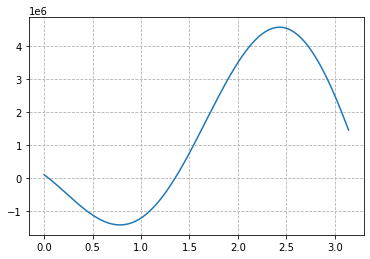

In [90]:
plt.plot(df0.Theta, df0.V_exact)

In [91]:
df_params

,param,value
0,c_0000,-1.122740e+06
1,c_0010,-4.154860e+05
2,c_0011,-7.542105e+05
3,c_0020,-2.810550e+05
4,c_0021,-2.142077e+06
...,...,...
77,nmax,2.000000e+00
78,lmax,2.000000e+00
79,alpha0,0.000000e+00
80,beta0,1.570796e+00


In [64]:
np.pi/2

1.5707963267948966

In [123]:
# fit!
result = model.fit(df_['V_obs'], Bs=df_['B'], ts=df_['Temp'], thetas=df_['Theta'], phis=df_['Phi'],
                   params=params, weights= 1/df_['sigma_V'], method='leastsq')#_squares')

In [40]:
# leastsq
result

In [125]:
result.nfree

15768

In [126]:
# probability to exceed
1 - chi2.cdf(result.chisqr, result.nfree)

0.5081300409923528

In [90]:
np.max(result.covar)

578.234934854466

In [185]:
v = np.sqrt(np.diag(result.covar))

In [187]:
np.outer(v, v).shape

(73, 73)

In [189]:
# compute correlation matrix
v = np.sqrt(np.diag(result.covar))
outer_v = np.outer(v, v)
correlation = result.covar / outer_v
correlation[result.covar == 0] = 0

In [190]:
keys = [k for k in params.keys() if (k[:2] == 'c_') ]

In [191]:
len(keys)

72

In [192]:
df_corr = pd.DataFrame(correlation, columns=keys, index=keys)

ValueError: Shape of passed values is (73, 73), indices imply (72, 72)

In [193]:
df_corr

NameError: name 'df_corr' is not defined

In [96]:
df_corr.style.background_gradient(cmap='coolwarm', axis=None)

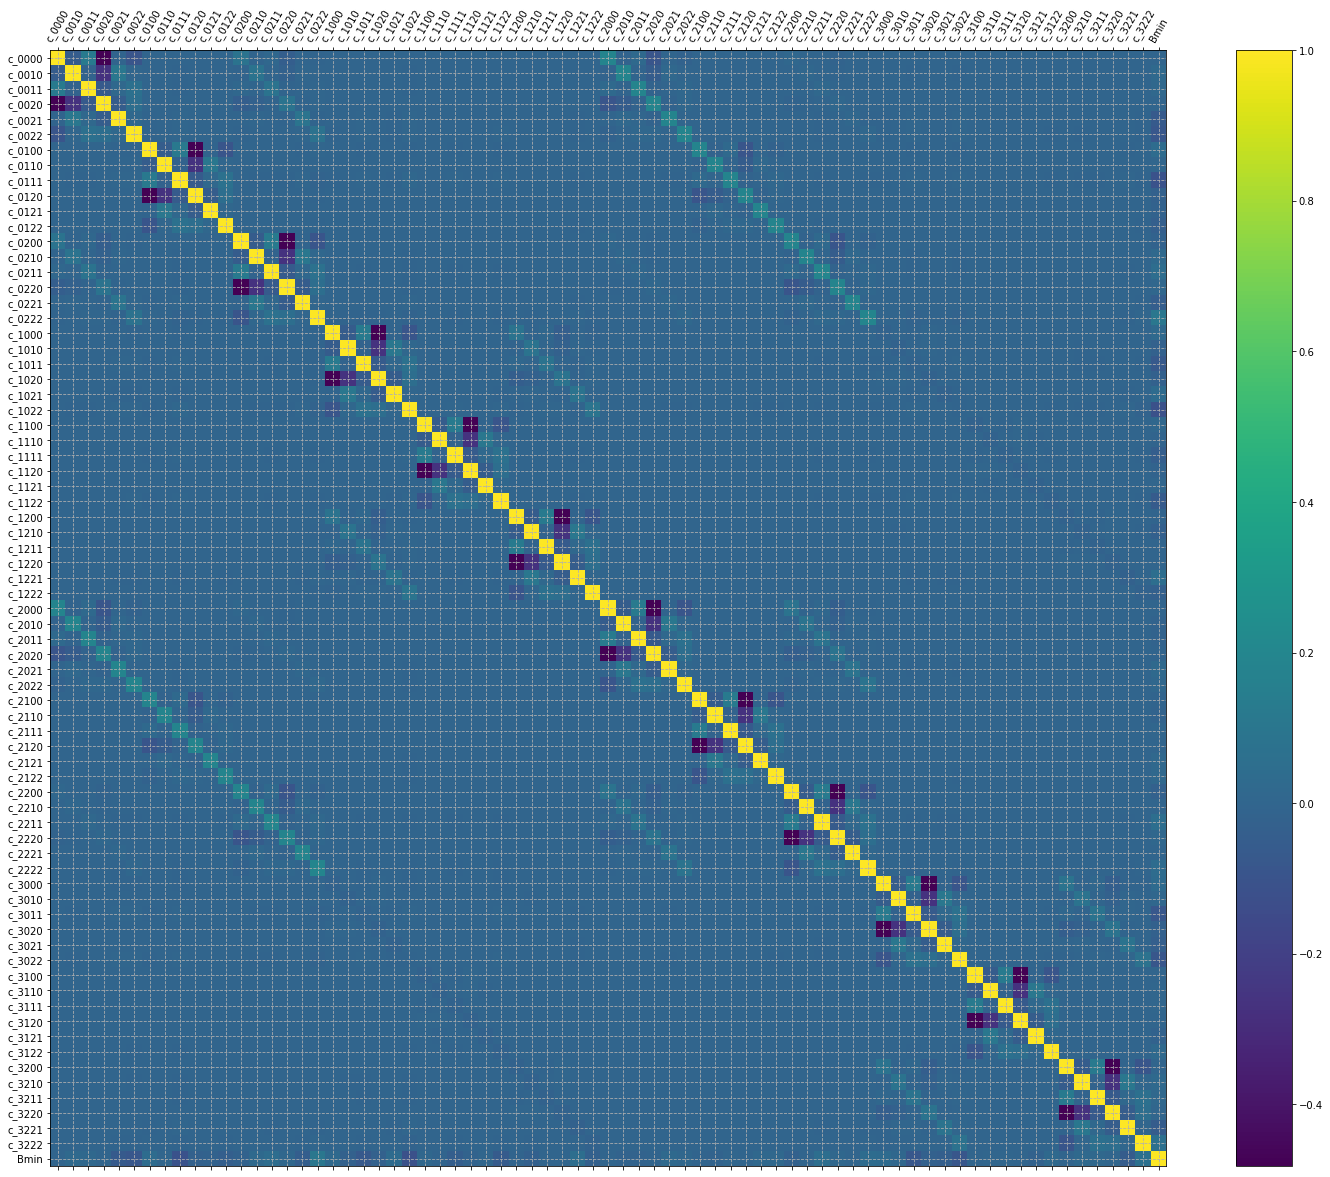

In [194]:
f = plt.figure(figsize=(25, 20))
#plt.matshow(np.clip(correlation, -1, 0.2), fignum=f.number)
plt.matshow(np.clip(correlation, -1, 1), fignum=f.number)
cb = plt.colorbar()
plt.xticks(range(correlation.shape[0]), labels=result.params.keys(), rotation=60, fontsize=10);
plt.yticks(range(correlation.shape[0]), labels=result.params.keys(), rotation=0, fontsize=10);
#f.savefig('/home/shared_data/hallcalib/fake_data/plots/cole_data_04_fit_corr_matrix.pdf')

- How long to fit?

In [102]:
%time result = model.fit(df_['V_obs'], Bs=df_['B'], ts=df_['Temp'], thetas=df_['Theta'], phis=df_['Phi'], \
                         params=params, weights= 1/df_['sigma_V'])

CPU times: user 13 s, sys: 16.8 ms, total: 13 s
Wall time: 11.7 s


- Darren said 30 min or 1 hour...definitely could be optimized!

In [104]:
# seconds per function eval, with leastsq
11.7 / 737

0.01587516960651289

# Validation data

In [252]:
len(df_)

5760

In [98]:
%time V_forward(df_['B'], df_['Temp'], df_['Theta'], df_['Phi'], **result.params)

CPU times: user 189 ms, sys: 12 ms, total: 201 ms
Wall time: 199 ms


0         -383125.443884
100       -383125.443884
200       -383125.443884
300       -383125.443884
18000     -473565.799605
               ...      
3098820     79179.533490
3116520   -177748.428679
3116620    -73814.806044
3116720     25634.378587
3116820   -140636.120774
Name: B, Length: 768, dtype: float64

In [272]:
V_forward_cheb2d(df_['B'], df_['Temp'], df_['Theta'], df_['Phi'], **result.params)

IndexError: index 2 is out of bounds for axis 1 with size 2

In [260]:
7.57 / .02

378.5

In [259]:
df_

,B,Temp,Theta,Phi,Theta_deg,Phi_deg,V_obs,sigma_V
0,0.0,10.0,0.000000,0.000000,0.0,0.0,49373.948919,50.0
25,0.0,10.0,0.000000,0.436332,0.0,25.0,49336.861489,50.0
50,0.0,10.0,0.000000,0.872665,0.0,50.0,49344.012691,50.0
75,0.0,10.0,0.000000,1.308997,0.0,75.0,49331.786667,50.0
100,0.0,10.0,0.000000,1.745329,0.0,100.0,49379.704953,50.0
...,...,...,...,...,...,...,...,...
3125770,2.0,40.0,3.054326,4.363323,175.0,250.0,-51229.757882,50.0
3125795,2.0,40.0,3.054326,4.799655,175.0,275.0,-51305.014140,50.0
3125820,2.0,40.0,3.054326,5.235988,175.0,300.0,-51380.171673,50.0
3125845,2.0,40.0,3.054326,5.672320,175.0,325.0,-51336.241071,50.0


In [256]:
30 * 60 / 11

163.63636363636363

In [257]:
.02 * 160

3.2

In [262]:
%time df['V_lsq'] = result.eval(Bs=df['B'], ts=df['Temp'], thetas=df['Theta'], phis=df['Phi'])

CPU times: user 3.76 s, sys: 459 ms, total: 4.22 s
Wall time: 3.45 s


In [99]:
df['V_lsq'] = result.eval(Bs=df['B'], ts=df['Temp'], thetas=df['Theta'], phis=df['Phi'])

In [237]:
eval_validation = result.eval(Bs=df['B'], ts=df['Temp'], thetas=df['Theta'], phis=df['Phi'])
                              #params=result.params, weights= 1/df['sigma_V'], method='least_squares', fit_kws={'max_nfev':1})

In [100]:
#df['V_lsq'] = eval_validation
df['V_res'] = df['V_obs'] - df['V_lsq']
df['V_res_rel'] = (df['V_obs'] - df['V_lsq']) / df['V_obs']

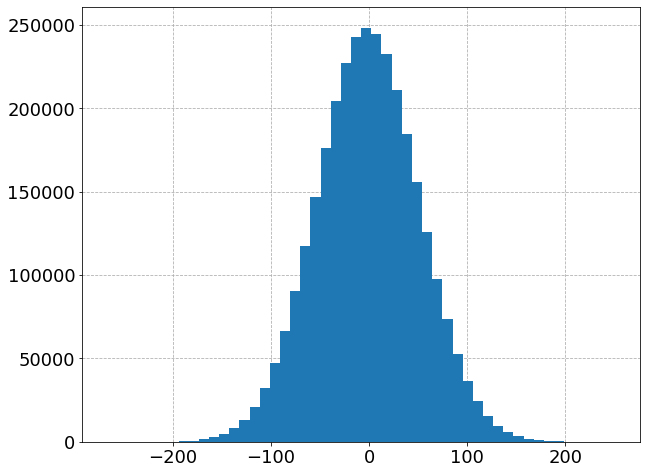

In [101]:
plt.hist(df['V_res'], bins=50);

In [102]:
df['V_res'].describe()

count    3.127680e+06
mean    -1.334271e+00
std      5.191792e+01
min     -2.667907e+02
25%     -3.634612e+01
50%     -1.396828e+00
75%      3.363408e+01
max      2.506388e+02
Name: V_res, dtype: float64

## Parameter Pulls

In [128]:
df_params

,param,value
0,c_0000,-1431.700783
1,c_0010,31871.566494
2,c_0011,65534.309230
3,c_0020,-191503.409425
4,c_0021,84041.868663
...,...,...
74,tmin,10.000000
75,tmax,40.000000
76,kmax,3.000000
77,nmax,2.000000


In [129]:
df_params['key'] = df_params['param']

In [127]:
df_params['key'] = pd.Series([f'' for row in df_params.itertuples() if row.param[0:2] == 'c_'])

AttributeError: 'Pandas' object has no attribute 'k'

In [130]:
keys = list(df_params['key'])
keys

['c_0000',
 'c_0010',
 'c_0011',
 'c_0020',
 'c_0021',
 'c_0022',
 'c_0100',
 'c_0110',
 'c_0111',
 'c_0120',
 'c_0121',
 'c_0122',
 'c_0200',
 'c_0210',
 'c_0211',
 'c_0220',
 'c_0221',
 'c_0222',
 'c_1000',
 'c_1010',
 'c_1011',
 'c_1020',
 'c_1021',
 'c_1022',
 'c_1100',
 'c_1110',
 'c_1111',
 'c_1120',
 'c_1121',
 'c_1122',
 'c_1200',
 'c_1210',
 'c_1211',
 'c_1220',
 'c_1221',
 'c_1222',
 'c_2000',
 'c_2010',
 'c_2011',
 'c_2020',
 'c_2021',
 'c_2022',
 'c_2100',
 'c_2110',
 'c_2111',
 'c_2120',
 'c_2121',
 'c_2122',
 'c_2200',
 'c_2210',
 'c_2211',
 'c_2220',
 'c_2221',
 'c_2222',
 'c_3000',
 'c_3010',
 'c_3011',
 'c_3020',
 'c_3021',
 'c_3022',
 'c_3100',
 'c_3110',
 'c_3111',
 'c_3120',
 'c_3121',
 'c_3122',
 'c_3200',
 'c_3210',
 'c_3211',
 'c_3220',
 'c_3221',
 'c_3222',
 'Bmin',
 'Bmax',
 'tmin',
 'tmax',
 'kmax',
 'nmax',
 'lmax']

In [243]:
df_params.query('k == 1 & n == 1 & l == 1 & m == 0')['val'].values[0]

102925.18008477692

In [133]:
keys

['c_0000',
 'c_0010',
 'c_0011',
 'c_0020',
 'c_0021',
 'c_0022',
 'c_0100',
 'c_0110',
 'c_0111',
 'c_0120',
 'c_0121',
 'c_0122',
 'c_0200',
 'c_0210',
 'c_0211',
 'c_0220',
 'c_0221',
 'c_0222',
 'c_1000',
 'c_1010',
 'c_1011',
 'c_1020',
 'c_1021',
 'c_1022',
 'c_1100',
 'c_1110',
 'c_1111',
 'c_1120',
 'c_1121',
 'c_1122',
 'c_1200',
 'c_1210',
 'c_1211',
 'c_1220',
 'c_1221',
 'c_1222',
 'c_2000',
 'c_2010',
 'c_2011',
 'c_2020',
 'c_2021',
 'c_2022',
 'c_2100',
 'c_2110',
 'c_2111',
 'c_2120',
 'c_2121',
 'c_2122',
 'c_2200',
 'c_2210',
 'c_2211',
 'c_2220',
 'c_2221',
 'c_2222',
 'c_3000',
 'c_3010',
 'c_3011',
 'c_3020',
 'c_3021',
 'c_3022',
 'c_3100',
 'c_3110',
 'c_3111',
 'c_3120',
 'c_3121',
 'c_3122',
 'c_3200',
 'c_3210',
 'c_3211',
 'c_3220',
 'c_3221',
 'c_3222',
 'Bmin',
 'Bmax',
 'tmin',
 'tmax',
 'kmax',
 'nmax',
 'lmax']

In [140]:
df_params.query('param == "c_0000"')

,param,value,key
0,c_0000,-1431.700783,c_0000


In [161]:
pulls = []
residuals = []
for k in result.params.keys():
    if k[:2] == 'c_':
        if k in keys:
            #true_val = df_params.query(f'k == {k[2]} & n == {k[3]} & l == {k[4]} & m == {k[5]}')['val'].values[0]
            #print('in first if')
            true_val = df_params.query(f'param == "{k}"')['value'].values[0]# == {k[2]} & n == {k[3]} & l == {k[4]} & m == {k[5]}')['val'].values[0]
        else:
            true_val = 0
        #print('finished if')
        pull = (result.params[k].value - true_val) / result.params[k].stderr
        res = (result.params[k].value - true_val) / true_val #/ result.params[k].stderr
        if abs(pull) > 1:
            print(f'{k}={true_val} (true), pull = {pull} > +-1')
        pulls.append(pull)
        residuals.append(res)
pulls = np.array(pulls)
residuals = np.array(residuals)

c_0021=84041.86866344385 (true), pull = 1.4694141681668622 > +-1
c_0022=-50232.14601891709 (true), pull = -1.6095693890090124 > +-1
c_0200=206166.34575813194 (true), pull = 1.274743316125764 > +-1
c_0211=102528.44251941863 (true), pull = -2.02102558642056 > +-1
c_0220=102312.96884467501 (true), pull = -1.2930073176203343 > +-1
c_1021=-110023.19598151988 (true), pull = 1.2774597751406342 > +-1
c_1110=-49111.02215530521 (true), pull = -1.4847494928242222 > +-1
c_2000=-42539.17629966042 (true), pull = 1.2058248166003342 > +-1
c_2020=-139707.82136136098 (true), pull = -1.2233777444945 > +-1
c_2022=19951.411064384225 (true), pull = -1.0351913502029302 > +-1
c_2111=-100767.96163692421 (true), pull = 1.4648121523878346 > +-1
c_3000=27234.542800496027 (true), pull = 2.013162047508266 > +-1
c_3020=107578.69935459574 (true), pull = -2.0215181693477544 > +-1
c_3110=-30651.808923126933 (true), pull = 1.584081678061539 > +-1
c_3211=49944.05720765748 (true), pull = -1.3082328350966812 > +-1


In [132]:
result.params

name,value,standard error,relative error,initial value,min,max,vary
c_0000,-1360.52577,95.3686708,(7.01%),0,-inf,inf,True
c_0010,31871.0661,0.83589768,(0.00%),0,-inf,inf,True
c_0011,65548.3846,15.8914814,(0.02%),0,-inf,inf,True
c_0020,-191536.822,43.3319230,(0.02%),0,-inf,inf,True
c_0021,84052.3850,7.15684946,(0.01%),0,-inf,inf,True
c_0022,-50394.4386,100.829814,(0.20%),0,-inf,inf,True
c_0100,-19685.7540,139.120891,(0.71%),0,-inf,inf,True
c_0110,81839.4504,1.21938345,(0.00%),0,-inf,inf,True
c_0111,-41163.5797,23.1820413,(0.06%),0,-inf,inf,True
c_0120,104475.093,63.2112870,(0.06%),0,-inf,inf,True


In [146]:
np.mean(pulls)

0.02135755659794762

In [147]:
np.std(pulls)

0.8428873013057658

In [152]:
np.mean(pulls)

0.02135755659794762

In [153]:
np.std(pulls)

0.8428873013057658

(array([ 2.,  5.,  6.,  9., 10., 14., 14.,  6.,  5.,  1.]),
 array([-2.02151817, -1.61805015, -1.21458213, -0.8111141 , -0.40764608,
        -0.00417806,  0.39928996,  0.80275798,  1.206226  ,  1.60969403,
         2.01316205]),
 <a list of 10 Patch objects>)

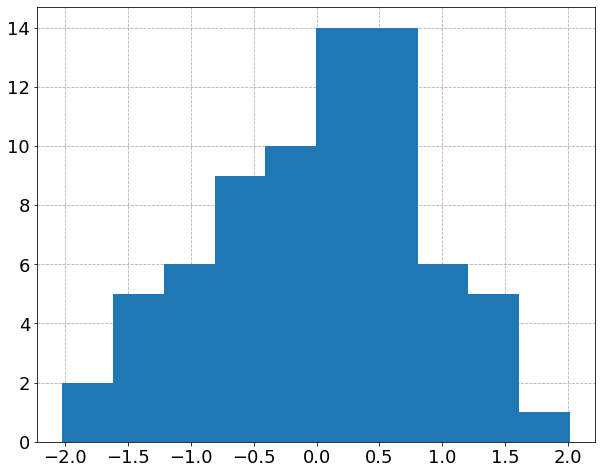

In [155]:
plt.hist(pulls, bins=10)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,
         4., 59.,  2.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-0.04971361, -0.04624811, -0.04278261, -0.03931711, -0.0358516 ,
        -0.0323861 , -0.0289206 , -0.0254551 , -0.0219896 , -0.0185241 ,
        -0.0150586 , -0.0115931 , -0.0081276 , -0.0046621 , -0.00119659,
         0.00226891,  0.00573441,  0.00919991,  0.01266541,  0.01613091,
         0.01959641,  0.02306191,  0.02652741,  0.02999291,  0.03345842,
         0.03692392]),
 <a list of 25 Patch objects>)

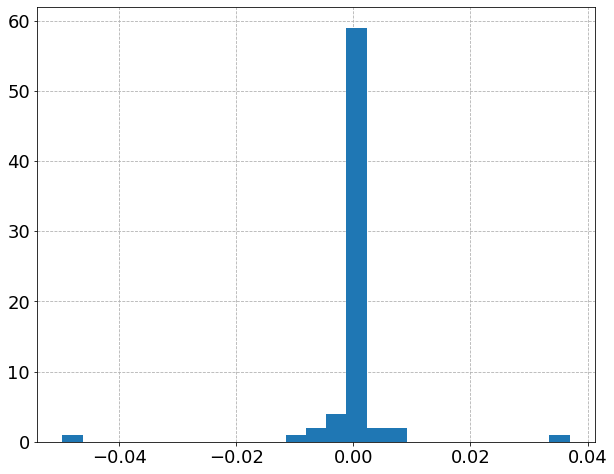

In [163]:
plt.hist(residuals, bins=25)

In [156]:
l = 7
(l+1)*(l+2)/2

36.0

In [192]:
len(df)

3127680

In [191]:
eval_validation

0          49330.900803
1          49330.900803
2          49330.900803
3          49330.900803
4          49330.900803
               ...     
3127675   -51455.380270
3127676   -51455.380270
3127677   -51455.380270
3127678   -51455.380270
3127679   -51455.380270
Name: B, Length: 3127680, dtype: float64

In [181]:
[int(i[2]) for i in result.params.keys() if i[:2] == 'c_']

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3]

In [185]:
dict(params)['c_0000'].value

0

In [168]:
dict(result.params)['c_0000']

<Parameter 'c_0000', value=-3.8616225684606604 +/- 4.12, bounds=[-inf:inf]>

In [170]:
{'a':1}['a']

1

In [171]:
type(result.params)

lmfit.parameter.Parameters

In [172]:
type(params)

lmfit.parameter.Parameters